In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

df = pd.read_csv("/kaggle/input/exoplanet-nasa-dataset/TOI_2025.10.02_23.17.39.csv")
df = df.dropna(axis=1)

df

2025-10-03 15:53:47.828022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759506828.197187      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759506828.307127      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,decstr,...,st_distlim,st_distsymerr,st_tefflim,st_teffsymerr,st_logglim,st_loggsymerr,st_radlim,st_radsymerr,toi_created,rowupdate
0,1,1000.01,1000,50365310,5.036531e+07,1,FP,07h29m25.85s,112.357708,-12d41m45.46s,...,0,1,0,1,0,1,0,1,7/24/2019 15:58,9/9/2024 10:08
1,2,1001.01,1001,88863718,8.886372e+07,1,PC,08h10m19.31s,122.580465,-05d30m49.87s,...,0,1,0,1,0,1,0,1,7/24/2019 15:58,4/3/2023 14:31
2,3,1002.01,1002,124709665,1.247097e+08,1,FP,06h58m54.47s,104.726966,-10d34m49.64s,...,0,1,0,1,0,1,0,1,7/24/2019 15:58,7/11/2022 16:02
3,4,1003.01,1003,106997505,1.069975e+08,1,FP,07h22m14.39s,110.559945,-25d12m25.26s,...,0,1,0,1,0,1,0,1,7/24/2019 15:58,2/23/2022 10:10
4,5,1004.01,1004,238597883,2.385979e+08,1,FP,08h08m42.77s,122.178195,-48d48m10.12s,...,0,1,0,1,0,1,0,1,7/24/2019 15:58,9/9/2024 10:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7698,7699,995.01,995,317951248,3.179512e+08,1,FP,07h23m14.75s,110.811443,+05d33m46.26s,...,0,1,0,1,0,1,0,1,7/24/2019 15:58,10/29/2021 12:59
7699,7700,996.01,996,142918609,1.429186e+08,1,FP,07h57m23.99s,119.349948,-19d30m57.65s,...,0,1,0,1,0,1,0,1,7/24/2019 15:58,10/29/2021 12:59
7700,7701,997.01,997,341729521,3.417295e+08,1,FP,08h05m16.69s,121.319521,-59d34m47.27s,...,0,1,0,1,0,1,0,1,7/24/2019 15:58,9/9/2024 10:08
7701,7702,998.01,998,54390047,5.439005e+07,1,FP,07h53m16.69s,118.319555,-14d13m07.76s,...,0,1,0,1,0,1,0,1,7/24/2019 15:58,9/9/2024 10:08


In [46]:
# keep only PC and FP
df_binary = df[df["tfopwg_disp"].isin(["PC", "FP"])]

# Separate the two classes
pc = df_binary[df_binary["tfopwg_disp"] == "PC"]
fp = df_binary[df_binary["tfopwg_disp"] == "FP"]

# Choose the minority class size (FP has 1197)
min_size = min(len(pc), len(fp))

# Downsample both classes to the same size
pc_bal = pc.sample(n=min_size, random_state=42)
fp_bal = fp.sample(n=min_size, random_state=42)

# Combine and shuffle
df_bal = pd.concat([pc_bal, fp_bal], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print(df_bal["tfopwg_disp"].value_counts())
print(df_bal.shape)


tfopwg_disp
PC    1197
FP    1197
Name: count, dtype: int64
(2394, 39)


In [60]:
# Count how many samples per class
class_counts = df_binary["tfopwg_disp"].value_counts()

print("Samples per class:")
print(class_counts)

# If you want it as a percentage too:
print("\nPercentage distribution:")
print((class_counts / len(df)) * 100)

Samples per class:
tfopwg_disp
PC    4679
FP    1197
Name: count, dtype: int64

Percentage distribution:
tfopwg_disp
PC    60.742568
FP    15.539400
Name: count, dtype: float64


In [61]:
# Define target
y = df_binary["tfopwg_disp"]

# Columns to drop (meta, IDs, string coords, and flags/errors you usually don't want as features)
drop_cols = [
    "tfopwg_disp", "rowid", "toi_created", "rowupdate", "rastr", "decstr",
    "toi", "toipfx", "tid", "ctoi_alias",          # identifiers
    # flags / limit columns
    "st_pmralim", "st_pmrasymerr", "st_pmdeclim", "st_pmdecsymerr",
    "pl_tranmidlim", "pl_tranmidsymerr",
    "pl_orbperlim", "pl_orbpersymerr",
    "pl_trandurhlim", "pl_trandurhsymerr",
    "pl_trandeplim", "pl_trandepsymerr",
    "pl_radelim", "pl_radesymerr",
    "pl_insollim", "pl_insolsymerr",
    "pl_eqtlim", "pl_eqtsymerr",
    "st_tmaglim", "st_tmagsymerr",
    "st_distlim", "st_distsymerr",
    "st_tefflim", "st_teffsymerr",
    "st_logglim", "st_loggsymerr",
    "st_radlim", "st_radsymerr"
]

# Drop unused columns safely (ignore errors if some are missing)
X = df_binary.drop(columns=drop_cols, errors="ignore")

print("Remaining feature count:", X.shape[1])
print("Remaining features:", list(X.columns))


Remaining feature count: 9
Remaining features: ['pl_pnum', 'ra', 'dec', 'pl_tranmid', 'pl_trandurh', 'pl_trandep', 'st_tmag', 'st_tmagerr1', 'st_tmagerr2']


In [62]:

le = LabelEncoder()
y = le.fit_transform(y)

# To see mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


{'FP': 0, 'PC': 1}


In [64]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [65]:
X_train.shape

(4700, 9)

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier  # if available
from lightgbm import LGBMClassifier  # if available


Class weights: {0: 2.4555903866248694, 1: 0.6278386321132782}


Tuning Models:   0%|          | 0/6 [00:00<?, ?it/s]


>>> Tuning: Logistic Regression
Fitting 5 folds for each of 8 candidates, totalling 40 fits


Tuning Models:  17%|█▋        | 1/6 [00:01<00:06,  1.36s/it]

Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV F1 : 0.7915

>>> Tuning: SVM (RBF)
Fitting 5 folds for each of 16 candidates, totalling 80 fits


Tuning Models:  33%|███▎      | 2/6 [01:37<03:48, 57.05s/it]

Best params: {'clf__C': 0.1, 'clf__gamma': 0.001}
Best CV F1 : 0.8695

>>> Tuning: KNN
Fitting 5 folds for each of 16 candidates, totalling 80 fits


Tuning Models:  50%|█████     | 3/6 [01:39<01:36, 32.15s/it]

Best params: {'clf__n_neighbors': 7, 'clf__p': 1, 'clf__weights': 'distance'}
Best CV F1 : 0.8939

>>> Tuning: Decision Tree
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ....clf__C=0.01, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l2, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l2, clf__solver=liblinear; total time=   0.0s
[CV] END .....clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END .....clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END .clf__C=0.1, clf__penalty=l2, clf__solver=liblinear; total time=   0.0s
[CV] END .clf__C=0.1, clf__penalty=l2, clf__solver=liblinear; total time=   0.0s
[CV] END .......clf__C=1, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END ......clf__C=10, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END ......clf__C=10, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV

Tuning Models:  67%|██████▋   | 4/6 [01:41<00:40, 20.22s/it]

Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best CV F1 : 0.8515

>>> Tuning: Random Forest
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ....clf__C=0.01, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END .......clf__C=1, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END .......clf__C=1, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=1, clf__penalty=l2, clf__solver=liblinear; total time=   0.0s
[CV] END ......clf__C=10, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END ......clf__C=10, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END .......................clf__C=0.1, clf__gamma=scale; total time=   4.6s
[CV] END .........................clf__C=0.1, clf__gamma=0.1; total time=   4.3s
[CV] END .........................clf__C=0.1, clf__gamma=0.1; total time=   4.3s
[CV] END ........................clf__C=0.1, clf__gamma=0.01; total

Tuning Models:  83%|████████▎ | 5/6 [05:01<01:24, 84.84s/it]

Best params: {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV F1 : 0.9018

>>> Tuning: Gradient Boosting
Fitting 5 folds for each of 36 candidates, totalling 180 fits

[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=400; total time=   4.7s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=400; total time=   4.6s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   2.3s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   2.3s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=400; total time=   4.5s
[CV

Tuning Models: 100%|██████████| 6/6 [07:39<00:00, 76.54s/it] 

Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Best CV F1 : 0.9036

=== CV Summary (sorted by F1) ===
              Model  Best CV F1                                                                                                                            Best Params
  Gradient Boosting    0.903574                                     {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
      Random Forest    0.901795 {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
                KNN    0.893880                                                                       {'clf__n_neighbors': 7, 'clf__p': 1, 'clf__weights': 'distance'}
          SVM (RBF)    0.869463                                                                                                   {'clf__C': 0.1, 'clf__gamma': 0.001


=== Test Set Results (best-tuned models) ===
                     Accuracy  Precision  Recall     F1  ROC-AUC
Gradient Boosting      0.8478     0.8615  0.9637 0.9097   0.8315
Random Forest          0.8359     0.8576  0.9519 0.9023   0.8213
KNN                    0.8291     0.8571  0.9423 0.8977   0.7666
Decision Tree          0.7602     0.8479  0.8515 0.8497   0.6278
SVM (RBF)              0.7534     0.8589  0.8259 0.8420   0.7318
Logistic Regression    0.7143     0.9054  0.7158 0.7995   0.7579


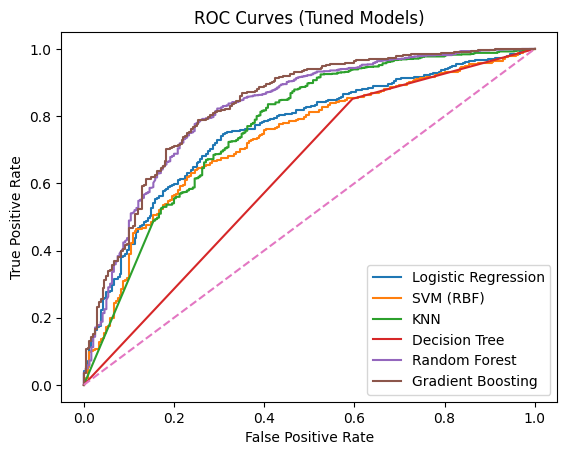

In [70]:
# ===============================
# Tuning + Cross-Validation + Progress
# ===============================
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# -------------------------------
# Class weights (safe to keep even if balanced)
# -------------------------------
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

# -------------------------------
# Pipelines (scaling where needed)
# -------------------------------
pipelines = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"))
    ]),
    "Gradient Boosting": Pipeline([
        ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
}

# -------------------------------
# Parameter grids (compact & effective)
# -------------------------------
param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "liblinear"],
    },
    "SVM (RBF)": {
        "clf__C": [0.1, 1, 10, 50],
        "clf__gamma": ["scale", 0.1, 0.01, 0.001],
    },
    "KNN": {
        "clf__n_neighbors": [3, 5, 7, 11],
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2],  # Manhattan / Euclidean
    },
    "Decision Tree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
    },
    "Random Forest": {
        "clf__n_estimators": [200, 400],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2],
        "clf__max_features": ["sqrt", "log2"],
    },
    "Gradient Boosting": {
        "clf__n_estimators": [200, 400],
        "clf__learning_rate": [0.05, 0.1, 0.2],
        "clf__max_depth": [2, 3, 4],
        "clf__subsample": [0.8, 1.0],
    },
}

# -------------------------------
# Cross-validation setup
# -------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# -------------------------------
# Helper: get probability scores
# -------------------------------
def get_proba_or_score(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(X)
        # min-max to [0,1] for ROC-AUC if needed
        s_min, s_max = s.min(), s.max()
        if s_max > s_min:
            return (s - s_min) / (s_max - s_min)
        else:
            return None
    else:
        return None

# -------------------------------
# Grid search with PROGRESS
# -------------------------------
cv_summary = []
best_models = {}

for name in tqdm(list(pipelines.keys()), desc="Tuning Models"):
    print(f"\n>>> Tuning: {name}")
    grid = GridSearchCV(
        estimator=pipelines[name],
        param_grid=param_grids[name],
        scoring="f1",           # try "roc_auc" if you prefer
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=2               # <--- detailed progress
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print("Best params:", grid.best_params_)
    print("Best CV F1 :", f"{grid.best_score_:.4f}")

    cv_summary.append({
        "Model": name,
        "Best CV F1": grid.best_score_,
        "Best Params": grid.best_params_
    })

cv_df = pd.DataFrame(cv_summary).sort_values("Best CV F1", ascending=False)
print("\n=== CV Summary (sorted by F1) ===")
print(cv_df.to_string(index=False))

# -------------------------------
# Final test evaluation
# -------------------------------
test_results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = get_proba_or_score(model, X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="binary")
    rec = recall_score(y_test, y_pred, average="binary")
    f1 = f1_score(y_test, y_pred, average="binary")
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    test_results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": auc
    }

test_df = pd.DataFrame(test_results).T.sort_values("F1", ascending=False)
print("\n=== Test Set Results (best-tuned models) ===")
print(test_df.to_string(float_format=lambda x: f"{x:.4f}"))

# -------------------------------
# (Optional) Plot ROC curves
# -------------------------------
plot_roc = True
if plot_roc:
    plt.figure()
    for name, model in best_models.items():
        y_proba = get_proba_or_score(model, X_test)
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=name)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Tuned Models)")
    plt.legend()
    plt.show()


In [71]:
import joblib

# Pick the best model from test_df
best_model_name = test_df.index[0]
best_model = best_models[best_model_name]

# Save it
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_')}.pkl")
print(f"Saved best model: {best_model_name}")


Saved best model: Gradient Boosting

[CV] END clf__learning_rate=0.05, clf__max_depth=2, clf__n_estimators=200, clf__subsample=1.0; total time=   1.7s
[CV] END clf__learning_rate=0.05, clf__max_depth=2, clf__n_estimators=200, clf__subsample=1.0; total time=   1.7s
[CV] END clf__learning_rate=0.05, clf__max_depth=2, clf__n_estimators=400, clf__subsample=0.8; total time=   3.0s
[CV] END clf__learning_rate=0.05, clf__max_depth=2, clf__n_estimators=400, clf__subsample=1.0; total time=   3.4s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, clf__n_estimators=200, clf__subsample=0.8; total time=   2.1s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, clf__n_estimators=200, clf__subsample=1.0; total time=   2.5s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, clf__n_estimators=200, clf__subsample=1.0; total time=   2.4s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, clf__n_estimators=400, clf__subsample=0.8; total time=   4.2s
[CV] END clf__learning_rate=0.05, clf__max_depth=3,

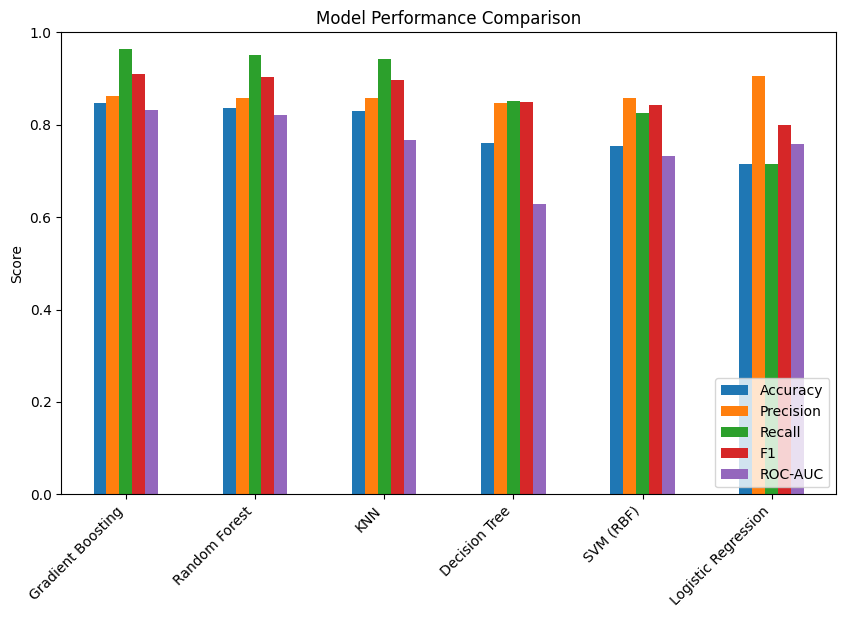

In [72]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

test_df[metrics].plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()


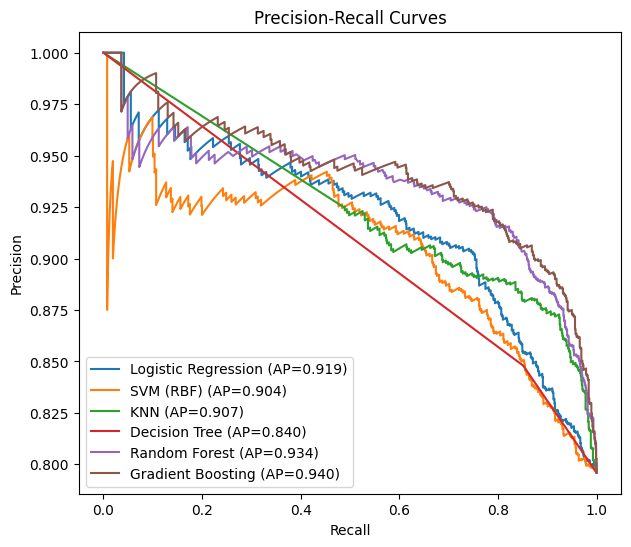

In [73]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(7,6))

for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        continue
    
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


In [ ]:
# ================================
# Deep Learning: CV Tuning + Save + Plots
# ================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# ----------------------------
# 1) Helper: build a Keras model
# ----------------------------
def build_mlp(input_dim,
              hidden_units=(64, 32),
              dropout=0.2,
              l2_reg=1e-4,
              lr=1e-3,
              batch_norm=True):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for units in hidden_units:
        model.add(layers.Dense(units, activation="relu",
                               kernel_regularizer=keras.regularizers.l2(l2_reg)))
        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ----------------------------
# 2) Define a small hyperparameter grid
# ----------------------------
param_grid = [
    {"hidden_units": [(128, 64, 32), (128, 64), (64, 32)],
     "dropout": [0.1, 0.2, 0.3],
     "l2_reg": [1e-5, 1e-4, 5e-4],
     "lr": [5e-4, 1e-3],
     "batch_norm": [True]},
]

# ----------------------------
# 3) CV setup
# ----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
input_dim = X_train.shape[1]

# We’ll scale features inside a simple sklearn Pipeline wrapper
scaler = StandardScaler()

# Callbacks for stability
def make_callbacks(tag="cv"):
    return [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6, monitor="val_loss"),
    ]

# ----------------------------
# 4) Grid + CV (score = mean F1 across folds)
# ----------------------------
cv_results = []
best_score = -np.inf
best_params = None
def take_idx(X, idx):
    # works for DataFrame or ndarray
    return X.iloc[idx] if hasattr(X, "iloc") else X[idx]

for grid in param_grid:
    # generate all combinations
    import itertools
    keys, values = zip(*grid.items())
    for combo in itertools.product(*values):
        params = dict(zip(keys, combo))
        fold_f1 = []

        print(f"\n>>> Testing params: {params}")
        for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
            X_tr, X_val = take_idx(X_train, tr_idx), take_idx(X_train, val_idx)
            y_tr, y_val = take_idx(y_train, tr_idx), take_idx(y_train, val_idx)

            # scale per-fold to avoid leakage
            X_tr_s = scaler.fit_transform(X_tr)
            X_val_s = scaler.transform(X_val)

            model = build_mlp(input_dim,
                              hidden_units=params["hidden_units"],
                              dropout=params["dropout"],
                              l2_reg=params["l2_reg"],
                              lr=params["lr"],
                              batch_norm=params["batch_norm"])

            history = model.fit(
                X_tr_s, y_tr,
                validation_data=(X_val_s, y_val),
                epochs=200,
                batch_size=64,
                callbacks=make_callbacks(),
                verbose=0
            )

            y_val_pred = (model.predict(X_val_s, verbose=0)[:,0] >= 0.5).astype(int)
            f1 = f1_score(y_val, y_val_pred)
            fold_f1.append(f1)
            print(f"  Fold {fold}: F1={f1:.4f}")

        mean_f1 = float(np.mean(fold_f1))
        cv_results.append({"params": params, "cv_f1": mean_f1})
        print(f"Mean CV F1 = {mean_f1:.4f}")

        if mean_f1 > best_score:
            best_score = mean_f1
            best_params = params

cv_df = pd.DataFrame(cv_results).sort_values("cv_f1", ascending=False)
print("\n=== CV results (top) ===")
print(cv_df.head(10).to_string(index=False))
print("\nBest params:", best_params, "Best CV F1:", f"{best_score:.4f}")

# ----------------------------
# 5) Refit best model on full training, validate on X_test each epoch
# ----------------------------
# Scale on full training and reuse for test
X_tr_s_full = scaler.fit_transform(X_train)
X_te_s = scaler.transform(X_test)

best_model = build_mlp(input_dim,
                       hidden_units=best_params["hidden_units"],
                       dropout=best_params["dropout"],
                       l2_reg=best_params["l2_reg"],
                       lr=best_params["lr"],
                       batch_norm=best_params["batch_norm"])

hist = best_model.fit(
    X_tr_s_full, y_train,
    validation_data=(X_te_s, y_test),     # your preference: test as validation each epoch
    epochs=300,
    batch_size=64,
    callbacks=make_callbacks("final"),
    verbose=1
)

# ----------------------------
# 6) Test metrics + curves
# ----------------------------
y_proba = best_model.predict(X_te_s, verbose=0)[:,0]
y_pred  = (y_proba >= 0.5).astype(int)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)
ap   = average_precision_score(y_test, y_proba)

print("\n=== Deep Learning Test Metrics ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")
print(f"AvgPrec:   {ap:.4f}")

# ----------------------------
# 7) Plots: learning curves, ROC, PR
# ----------------------------
import matplotlib.pyplot as plt

# Learning curves
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.show()

plt.figure()
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training vs Validation Accuracy")
plt.legend(); plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"MLP (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Deep Learning")
plt.legend(); plt.show()

# Precision-Recall
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(rec_curve, prec_curve, label=f"MLP (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Deep Learning")
plt.legend(); plt.show()

# ----------------------------
# 8) Save best model + scaler
# ----------------------------
best_model.save("best_dl_model.keras")        # Keras native format
import joblib
joblib.dump(scaler, "best_dl_scaler.pkl")
print("Saved: best_dl_model.keras and best_dl_scaler.pkl")

# (Optional) threshold tuning for best F1 on test
from numpy import argmax
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1s = 2*precisions*recalls/(precisions+recalls + 1e-12)
ix = argmax(f1s)
print(f"Best F1 threshold on test = {thresholds[ix]:.3f}, F1 = {f1s[ix]:.4f}")



>>> Testing params: {'hidden_units': (128, 64, 32), 'dropout': 0.1, 'l2_reg': 1e-05, 'lr': 0.0005, 'batch_norm': True}
  Fold 1: F1=0.9049
  Fold 2: F1=0.8981
  Fold 3: F1=0.9065
  Fold 4: F1=0.8958
  Fold 5: F1=0.8948
Mean CV F1 = 0.9000

>>> Testing params: {'hidden_units': (128, 64, 32), 'dropout': 0.1, 'l2_reg': 1e-05, 'lr': 0.001, 'batch_norm': True}
  Fold 1: F1=0.9014
  Fold 2: F1=0.8957
  Fold 3: F1=0.9064
  Fold 4: F1=0.8987
  Fold 5: F1=0.8951
Mean CV F1 = 0.8995

>>> Testing params: {'hidden_units': (128, 64, 32), 'dropout': 0.1, 'l2_reg': 0.0001, 'lr': 0.0005, 'batch_norm': True}
  Fold 1: F1=0.8989
  Fold 2: F1=0.9001
  Fold 3: F1=0.9066
  Fold 4: F1=0.8935
  Fold 5: F1=0.8960
Mean CV F1 = 0.8990

>>> Testing params: {'hidden_units': (128, 64, 32), 'dropout': 0.1, 'l2_reg': 0.0001, 'lr': 0.001, 'batch_norm': True}
  Fold 1: F1=0.9008
  Fold 2: F1=0.8909
  Fold 3: F1=0.9010
  Fold 4: F1=0.8957
  Fold 5: F1=0.8990
Mean CV F1 = 0.8975

>>> Testing params: {'hidden_units': (1